# Final Project


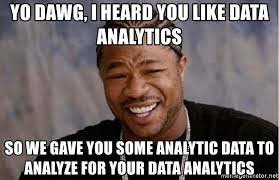  


- For your final project, you will be asked to analyse data from the following paper: [The Photoswitch Dataset: A Molecular Machine Learning Benchmark for the Advancement of Synthetic Chemistry](https://arxiv.org/abs/2008.03226). 

- In this data, you will find a variety of measurements done for a total of 405 molecules. However, the original paper's data only contains [SMILES](https://en.wikipedia.org/wiki/Simplified_molecular-input_line-entry_system) representations of the molecules, and in order to do anything useful with this we need to "featurise" them, which means to turn the character strings describing molecules into quantitative data that can then be used by the models to be learnt and fit on. Since this step can sometimes be a little involved (much research in cheminformatics is dedicated to this field!), I have prepared this for you. You will find the data featurised in three distinct ways:

    1. Using Morgan fingerprints as implemented in [RDKit](https://www.rdkit.org/docs/GettingStartedInPython.html#morgan-fingerprints-circular-fingerprints). This is a popular method to turn molecules of any shape into fixed sized vectors of binary data. The authors of the paper also use this method. 
    2. Using all molecular descriptors available in RDKit. I'm not sure if a comprehensive list of the descriptors exists, but they can all be looked up in the rdkit [documentation](https://www.rdkit.org/docs/source/rdkit.Chem.html). This is partially also used in the paper.
    3. Using the [mordred package](https://jcheminf.biomedcentral.com/articles/10.1186/s13321-018-0258-y), containing some 1826 descriptors, 1427 of which returned non-erroneous features for the molecules in the photoswitch dataset. For a complete list of all descriptors, click [here](https://mordred-descriptor.github.io/documentation/master/descriptors.html). This is not in the paper and may offer additional descriptors that could be important.


- In the Github repository for this course, you will find a folder entitled `final_project_data`, which contains the following: 
    * `Featurisation.ipynb` (My finished notebook with all the commented (!!!) code necessary to obtain the data below, in case you want to change parameters, in particular for fingerprints. Since this may be a little advanced, this is absolutely not mandatory!)
    * `photoswitches.csv` (this is the original data, SMILES + outcome measurements, i.e. transition wavelengths)
    * `morgan_fingerprints.csv` (SMILES + Morgan fingerprints)
    * `rdkit_descriptors.csv` (SMILES + rdkit descriptors)
    * `mordred_descriptors.csv` (SMILES + mordred descriptors)
    * `molecule_images` (A folder containing Chemdraw style pictures of all 405 molecules)


- Some ideas to get you started: 
    * Compare & contrast methods of featurisation (fingerprints have no real-life equivalents as opposed to descriptors etc)
    * Attempt to predict the other measurements (e.g. Extinction coefficient)
    * Supervised learning:
        * Improve model (particularly RFs) by pruning parameters 
        * Get most important predictors from RF, does that say anything about chemistry?
        * Compute scores from paper (RMSE, MAE, R^2) and compare, maybe improved? 
        * Could even try neural networks? 
    * Unsupervised learning:
        * Clustering 405 molecules should be somewhat of a tangible, tractable task, what groups of molecules are you seeing?
        * Paper does have advanced methods of dimensionality reduction, but maybe even PCA etc. can show stuff, too. Should be interesting to see if featurisation matters!


### Best of luck!


# Part 1 - Some housekeeping stuff

In [1]:
#we first import some useful libraries
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from rdkit import Chem # rdkit contains a number of molecular descriptors
from rdkit.Chem.rdmolops import GetAdjacencyMatrix
from rdkit.Chem import AllChem, Descriptors, MolFromSmiles
from rdkit.Chem.Crippen import MolLogP,MolMR
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import seaborn as sns

In [2]:
# Import main data and get list of SMILES
photoswitches_raw = pd.read_csv('./photoswitches.csv')  # Load the photoswitch dataset using pandas
smiles_list = photoswitches_raw['SMILES'].to_list()

In [3]:
# Let's have a look at our dataset
photoswitches_raw

,Unnamed: 0,SMILES,rate of thermal isomerisation from Z-E in s-1,Solvent used for thermal isomerisation rates,Z PhotoStationaryState,E PhotoStationaryState,E isomer pi-pi* wavelength in nm,Extinction,E isomer n-pi* wavelength in nm,Extinction coefficient in M-1 cm-1,...,TPSSh/6-31G** DFT Z isomer pi-pi* wavelength in nm,TPSSh/6-31G** DFT Z isomer n-pi* wavelength in nm,CAM-B3LYP/6-31G** DFT E isomer pi-pi* wavelength in nm,CAM-B3LYP/6-31G** DFT E isomer n-pi* wavelength in nm,CAM-B3LYP/6-31G** DFT Z isomer pi-pi* wavelength in nm,CAM-B3LYP/6-31G** DFT Z isomer n-pi* wavelength in nm,BHLYP/6-31G* DFT E isomer pi-pi* wavelength in nm,BHLYP/6-31G* DFT E isomer n-pi* wavelength in nm,BHLYP/6-31G* Z isomer pi-pi* wavelength in nm,BHLYP/6-31G* DFT Z isomer n-pi* wavelength in nm
0,0,C[N]1N=NC(=N1)N=NC2=CC=CC=C2,2.100000e-07,MeCN,76.0,72.0,310.0,1.67,442.0,0.0373,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,C[N]1C=NC(=N1)N=NC2=CC=CC=C2,3.800000e-07,MeCN,90.0,84.0,310.0,1.87,438.0,0.0505,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,C[N]1C=CC(=N1)N=NC2=CC=CC=C2,1.100000e-07,MeCN,98.0,97.0,320.0,1.46,425.0,0.0778,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,C[N]1C=C(C)C(=N1)N=NC2=CC=CC=C2,1.500000e-06,MeCN,96.0,87.0,325.0,1.74,428.0,0.0612,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,C[N]1C=C(C=N1)N=NC2=CC=CC=C2,7.600000e-09,MeCN,98.0,70.0,328.0,1.66,417.0,0.0640,...,295.0,410.0,305.0,427.0,256.0,401.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
400,400,OC%38=C%39N=CC=CC%39=C(/N=N/C%40=NC%41=CC(C)=C...,NaN,NaN,NaN,NaN,456.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
401,401,OC%42=C%43N=CC=CC%43=C(/N=N/C%44=NC%45=CC=CC=C...,NaN,NaN,NaN,NaN,437.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
402,402,N#CC1C(SC(/N=N/C2=NC(C=CC([N+]([O-])=O)=C3)=C3...,NaN,NaN,NaN,NaN,545.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
403,403,N#Cc5c(c6ccc(Cl)cc6)c(/N=N/C7=NC(C=CC([N+]([O-...,NaN,NaN,NaN,NaN,535.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# Don't you feel irritated seeing the same column twice? So, let's delete the second column!
photoswitches = photoswitches_raw.drop(['Unnamed: 0'],axis=1)
photoswitches

,SMILES,rate of thermal isomerisation from Z-E in s-1,Solvent used for thermal isomerisation rates,Z PhotoStationaryState,E PhotoStationaryState,E isomer pi-pi* wavelength in nm,Extinction,E isomer n-pi* wavelength in nm,Extinction coefficient in M-1 cm-1,Z isomer pi-pi* wavelength in nm,...,TPSSh/6-31G** DFT Z isomer pi-pi* wavelength in nm,TPSSh/6-31G** DFT Z isomer n-pi* wavelength in nm,CAM-B3LYP/6-31G** DFT E isomer pi-pi* wavelength in nm,CAM-B3LYP/6-31G** DFT E isomer n-pi* wavelength in nm,CAM-B3LYP/6-31G** DFT Z isomer pi-pi* wavelength in nm,CAM-B3LYP/6-31G** DFT Z isomer n-pi* wavelength in nm,BHLYP/6-31G* DFT E isomer pi-pi* wavelength in nm,BHLYP/6-31G* DFT E isomer n-pi* wavelength in nm,BHLYP/6-31G* Z isomer pi-pi* wavelength in nm,BHLYP/6-31G* DFT Z isomer n-pi* wavelength in nm
0,C[N]1N=NC(=N1)N=NC2=CC=CC=C2,2.100000e-07,MeCN,76.0,72.0,310.0,1.67,442.0,0.0373,290.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,C[N]1C=NC(=N1)N=NC2=CC=CC=C2,3.800000e-07,MeCN,90.0,84.0,310.0,1.87,438.0,0.0505,272.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,C[N]1C=CC(=N1)N=NC2=CC=CC=C2,1.100000e-07,MeCN,98.0,97.0,320.0,1.46,425.0,0.0778,272.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,C[N]1C=C(C)C(=N1)N=NC2=CC=CC=C2,1.500000e-06,MeCN,96.0,87.0,325.0,1.74,428.0,0.0612,286.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,C[N]1C=C(C=N1)N=NC2=CC=CC=C2,7.600000e-09,MeCN,98.0,70.0,328.0,1.66,417.0,0.0640,275.0,...,295.0,410.0,305.0,427.0,256.0,401.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
400,OC%38=C%39N=CC=CC%39=C(/N=N/C%40=NC%41=CC(C)=C...,NaN,NaN,NaN,NaN,456.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
401,OC%42=C%43N=CC=CC%43=C(/N=N/C%44=NC%45=CC=CC=C...,NaN,NaN,NaN,NaN,437.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
402,N#CC1C(SC(/N=N/C2=NC(C=CC([N+]([O-])=O)=C3)=C3...,NaN,NaN,NaN,NaN,545.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
403,N#Cc5c(c6ccc(Cl)cc6)c(/N=N/C7=NC(C=CC([N+]([O-...,NaN,NaN,NaN,NaN,535.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
#Identify the missing values in each attribute 
# Also we can have a quick glimpse of each descriptor used in the papaer 
photoswitches.isnull().sum()

SMILES                                                      0
rate of thermal isomerisation from Z-E in s-1             330
Solvent used for thermal isomerisation rates              353
Z PhotoStationaryState                                    329
E PhotoStationaryState                                    331
E isomer pi-pi* wavelength in nm                           13
Extinction                                                372
E isomer n-pi* wavelength in nm                           264
Extinction coefficient in M-1 cm-1                        379
Z isomer pi-pi* wavelength in nm                          312
Extinction.1                                              393
Z isomer n-pi* wavelength in nm                           282
Extinction coefficient in M-1 cm-1.1                      382
Wiberg index                                              390
E-Z irradiation wavelength in nm                          341
Z-E irradiation wavelength                                341
Irradiat

In [8]:
photoswitches['SMILES']

0                           C[N]1N=NC(=N1)N=NC2=CC=CC=C2
1                           C[N]1C=NC(=N1)N=NC2=CC=CC=C2
2                           C[N]1C=CC(=N1)N=NC2=CC=CC=C2
3                        C[N]1C=C(C)C(=N1)N=NC2=CC=CC=C2
4                           C[N]1C=C(C=N1)N=NC2=CC=CC=C2
                             ...                        
400    OC%38=C%39N=CC=CC%39=C(/N=N/C%40=NC%41=CC(C)=C...
401    OC%42=C%43N=CC=CC%43=C(/N=N/C%44=NC%45=CC=CC=C...
402    N#CC1C(SC(/N=N/C2=NC(C=CC([N+]([O-])=O)=C3)=C3...
403    N#Cc5c(c6ccc(Cl)cc6)c(/N=N/C7=NC(C=CC([N+]([O-...
404    N#CC9C(SC(/N=N/C%10=NC(C=CC([N+]([O-])=O)=C%11...
Name: SMILES, Length: 405, dtype: object

In [53]:
#Identify which columns are numerical and categorical (this can help us with the decision of the learning algorithms later):
photoswitches.dtypes

SMILES                                                     object
rate of thermal isomerisation from Z-E in s-1             float64
Solvent used for thermal isomerisation rates               object
Z PhotoStationaryState                                    float64
E PhotoStationaryState                                    float64
E isomer pi-pi* wavelength in nm                          float64
Extinction                                                float64
E isomer n-pi* wavelength in nm                           float64
Extinction coefficient in M-1 cm-1                        float64
Z isomer pi-pi* wavelength in nm                          float64
Extinction.1                                              float64
Z isomer n-pi* wavelength in nm                           float64
Extinction coefficient in M-1 cm-1.1                      float64
Wiberg index                                              float64
E-Z irradiation wavelength in nm                           object
Z-E irradi

In [322]:
photoswitches_columns = photoswitches.columns[1:].values.tolist()
photoswitches_columns =photoswitches.columns[np.where(photoswitches.dtypes != "object")] 
photoswitches_subset = photoswitches[photoswitches_columns]
photoswitches_subset

,rate of thermal isomerisation from Z-E in s-1,Z PhotoStationaryState,E PhotoStationaryState,E isomer pi-pi* wavelength in nm,Extinction,E isomer n-pi* wavelength in nm,Extinction coefficient in M-1 cm-1,Z isomer pi-pi* wavelength in nm,Extinction.1,Z isomer n-pi* wavelength in nm,...,TPSSh/6-31G** DFT Z isomer pi-pi* wavelength in nm,TPSSh/6-31G** DFT Z isomer n-pi* wavelength in nm,CAM-B3LYP/6-31G** DFT E isomer pi-pi* wavelength in nm,CAM-B3LYP/6-31G** DFT E isomer n-pi* wavelength in nm,CAM-B3LYP/6-31G** DFT Z isomer pi-pi* wavelength in nm,CAM-B3LYP/6-31G** DFT Z isomer n-pi* wavelength in nm,BHLYP/6-31G* DFT E isomer pi-pi* wavelength in nm,BHLYP/6-31G* DFT E isomer n-pi* wavelength in nm,BHLYP/6-31G* Z isomer pi-pi* wavelength in nm,BHLYP/6-31G* DFT Z isomer n-pi* wavelength in nm
0,2.100000e-07,76.0,72.0,310.0,1.67,442.0,0.0373,290.0,0.243,428.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3.800000e-07,90.0,84.0,310.0,1.87,438.0,0.0505,272.0,0.489,434.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.100000e-07,98.0,97.0,320.0,1.46,425.0,0.0778,272.0,0.908,422.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.500000e-06,96.0,87.0,325.0,1.74,428.0,0.0612,286.0,0.515,438.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,7.600000e-09,98.0,70.0,328.0,1.66,417.0,0.0640,275.0,0.806,403.0,...,295.0,410.0,305.0,427.0,256.0,401.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
400,NaN,NaN,NaN,456.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
401,NaN,NaN,NaN,437.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
402,NaN,NaN,NaN,545.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
403,NaN,NaN,NaN,535.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
#so, how many molecules do we have?
len(smiles_list)

405

In [13]:
# Initiate a list of rdkit molecules
rdkit_mols = [MolFromSmiles(smiles) for smiles in smiles_list]

In [9]:
from rdkit.Chem.Draw import IPythonConsole #Needed to show molecules

smiles = photoswitches.to_numpy()
print(smiles)

[['C[N]1N=NC(=N1)N=NC2=CC=CC=C2' 2.1e-07 'MeCN' ... nan nan nan]
 ['C[N]1C=NC(=N1)N=NC2=CC=CC=C2' 3.8e-07 'MeCN' ... nan nan nan]
 ['C[N]1C=CC(=N1)N=NC2=CC=CC=C2' 1.1e-07 'MeCN' ... nan nan nan]
 ...
 ['N#CC1C(SC(/N=N/C2=NC(C=CC([N+]([O-])=O)=C3)=C3S2)C1C4CCCCC4)N' nan nan
  ... nan nan nan]
 ['N#Cc5c(c6ccc(Cl)cc6)c(/N=N/C7=NC(C=CC([N+]([O-])=O)=C8)=C8S7)sc5N' nan
  nan ... nan nan nan]
 ['N#CC9C(SC(/N=N/C%10=NC(C=CC([N+]([O-])=O)=C%11)=C%11S%10)C9C%12CCC(OC)CC%12)N'
  nan nan ... nan nan nan]]


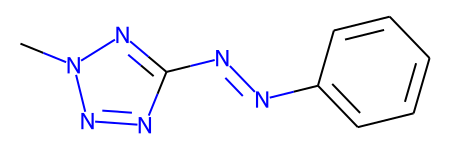

In [367]:
# Draw the structure 
smiles = photoswitches['SMILES'].values
test_mol= Chem.MolFromSmiles(smiles[0])

# Visualize the structure
test_mol

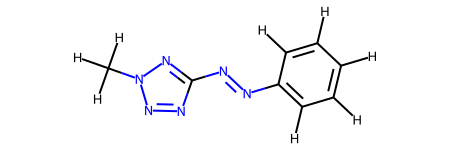

In [11]:
Chem.AddHs(test_mol) #add some Hydrogens hehe

# RDKIT Descriptors

# Morgan Fingerprints

In [15]:
## Get Morgan fingerprints, note the parameters!
# This is a popular method to turn molecules of any shape 
# into fixed sized vectors of binary data. The authors of the paper also use this method.
morgan_fingerprints = [AllChem.GetMorganFingerprintAsBitVect(mol, radius=3, nBits=2048) for mol in rdkit_mols]
morgan_fingerprints = np.asarray(morgan_fingerprints)

In [16]:
# Turn into pandas dataframe and add smiles as a first column
morgan_fingerprints = pd.DataFrame(data = morgan_fingerprints)
morgan_fingerprints.insert(0, "SMILES", smiles_list)

In [17]:
morgan_fingerprints

,SMILES,0,1,2,3,4,5,6,7,8,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,C[N]1N=NC(=N1)N=NC2=CC=CC=C2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,C[N]1C=NC(=N1)N=NC2=CC=CC=C2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,C[N]1C=CC(=N1)N=NC2=CC=CC=C2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,C[N]1C=C(C)C(=N1)N=NC2=CC=CC=C2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,C[N]1C=C(C=N1)N=NC2=CC=CC=C2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
400,OC%38=C%39N=CC=CC%39=C(/N=N/C%40=NC%41=CC(C)=C...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
401,OC%42=C%43N=CC=CC%43=C(/N=N/C%44=NC%45=CC=CC=C...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
402,N#CC1C(SC(/N=N/C2=NC(C=CC([N+]([O-])=O)=C3)=C3...,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
403,N#Cc5c(c6ccc(Cl)cc6)c(/N=N/C7=NC(C=CC([N+]([O-...,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [18]:
morgan = morgan_fingerprints.to_csv("morgan_fingerprints.csv")

In [19]:
# Next, rdkit's own descriptors
from rdkit.Chem import Descriptors

In [20]:
# A list of desriptors
Descriptors.descList

[('MaxEStateIndex',
  <function rdkit.Chem.EState.EState.MaxEStateIndex(mol, force=1)>),
 ('MinEStateIndex',
  <function rdkit.Chem.EState.EState.MinEStateIndex(mol, force=1)>),
 ('MaxAbsEStateIndex',
  <function rdkit.Chem.EState.EState.MaxAbsEStateIndex(mol, force=1)>),
 ('MinAbsEStateIndex',
  <function rdkit.Chem.EState.EState.MinAbsEStateIndex(mol, force=1)>),
 ('qed',
  <function rdkit.Chem.QED.qed(mol, w=QEDproperties(MW=0.66, ALOGP=0.46, HBA=0.05, HBD=0.61, PSA=0.06, ROTB=0.65, AROM=0.48, ALERTS=0.95), qedProperties=None)>),
 ('MolWt', <function rdkit.Chem.Descriptors.<lambda>(*x, **y)>),
 ('HeavyAtomMolWt', <function rdkit.Chem.Descriptors.HeavyAtomMolWt(x)>),
 ('ExactMolWt', <function rdkit.Chem.Descriptors.<lambda>(*x, **y)>),
 ('NumValenceElectrons',
  <function rdkit.Chem.Descriptors.NumValenceElectrons(mol)>),
 ('NumRadicalElectrons',
  <function rdkit.Chem.Descriptors.NumRadicalElectrons(mol)>),
 ('MaxPartialCharge',
  <function rdkit.Chem.Descriptors.MaxPartialCharge(mo

In [26]:
# Write a dictionary of name:function pairs for all descriptors
all_descriptors = {d[0]: d[1] for d in Descriptors.descList}

In [27]:
# Initialise a new pandas df
rdkit_descriptors = pd.DataFrame(data = {"SMILES": np.array((smiles_list)) })
rdkit_descriptors

,SMILES
0,C[N]1N=NC(=N1)N=NC2=CC=CC=C2
1,C[N]1C=NC(=N1)N=NC2=CC=CC=C2
2,C[N]1C=CC(=N1)N=NC2=CC=CC=C2
3,C[N]1C=C(C)C(=N1)N=NC2=CC=CC=C2
4,C[N]1C=C(C=N1)N=NC2=CC=CC=C2
...,...
400,OC%38=C%39N=CC=CC%39=C(/N=N/C%40=NC%41=CC(C)=C...
401,OC%42=C%43N=CC=CC%43=C(/N=N/C%44=NC%45=CC=CC=C...
402,N#CC1C(SC(/N=N/C2=NC(C=CC([N+]([O-])=O)=C3)=C3...
403,N#Cc5c(c6ccc(Cl)cc6)c(/N=N/C7=NC(C=CC([N+]([O-...


In [29]:
# Compute each descriptor (outer loop) for each molecule(inside)
for feature in all_descriptors:
    values = []
    for mol in rdkit_mols:
        values += [all_descriptors[feature](mol)]
    rdkit_descriptors[feature] = values

rdkit_descriptors

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  


,SMILES,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,C[N]1N=NC(=N1)N=NC2=CC=CC=C2,3.936481,0.260512,3.936481,0.260512,0.672275,188.194,180.130,188.081044,70,...,0,0,0,0,1,0,0,0,0,0
1,C[N]1C=NC(=N1)N=NC2=CC=CC=C2,3.976481,0.371623,3.976481,0.371623,0.676690,187.206,178.134,187.085795,70,...,0,0,0,0,0,0,0,0,0,0
2,C[N]1C=CC(=N1)N=NC2=CC=CC=C2,4.081997,0.621623,4.081997,0.621623,0.664734,186.218,176.138,186.090546,70,...,0,0,0,0,0,0,0,0,0,0
3,C[N]1C=C(C)C(=N1)N=NC2=CC=CC=C2,4.181534,0.667920,4.181534,0.667920,0.686454,200.245,188.149,200.106196,76,...,0,0,0,0,0,0,0,0,0,0
4,C[N]1C=C(C=N1)N=NC2=CC=CC=C2,4.061481,0.760512,4.061481,0.760512,0.664734,186.218,176.138,186.090546,70,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
400,OC%38=C%39N=CC=CC%39=C(/N=N/C%40=NC%41=CC(C)=C...,9.883085,0.134711,9.883085,0.134711,0.486213,334.404,320.292,334.088832,118,...,0,0,0,0,0,1,0,0,0,0
401,OC%42=C%43N=CC=CC%43=C(/N=N/C%44=NC%45=CC=CC=C...,9.822888,0.123414,9.822888,0.123414,0.541174,289.298,278.210,289.096360,106,...,0,0,0,0,0,0,0,0,0,0
402,N#CC1C(SC(/N=N/C2=NC(C=CC([N+]([O-])=O)=C3)=C3...,10.934342,-0.422909,10.934342,0.033505,0.424569,416.532,396.372,416.108916,146,...,1,0,0,0,0,1,0,0,0,0
403,N#Cc5c(c6ccc(Cl)cc6)c(/N=N/C7=NC(C=CC([N+]([O-...,10.920834,-0.461717,10.920834,0.014485,0.220871,440.897,431.825,439.991693,142,...,0,0,0,0,0,1,0,1,0,0


In [ ]:

# Use this line to get all columns of type float
# columns = chembl.columns[np.where(chembl.dtypes == "float64")] 

chembl_subset = chembl[columns].dropna()
chembl_subset

In [30]:
rdkit_descriptors.to_csv("rdkit_descriptors.csv")

In [278]:
rdkit_descriptors.isnull().sum()

SMILES               0
MaxEStateIndex       0
MinEStateIndex       0
MaxAbsEStateIndex    0
MinAbsEStateIndex    0
                    ..
fr_thiazole          0
fr_thiocyan          0
fr_thiophene         0
fr_unbrch_alkane     0
fr_urea              0
Length: 209, dtype: int64

In [296]:
rdkit_columns = rdkit_descriptors.columns[1:].values.tolist()
#new_mordred_descriptors
rdkit_columns =rdkit_descriptors.columns[np.where(rdkit_descriptors.dtypes != "object")] 
rdkit_descriptors_subset = rdkit_descriptors[rdkit_columns].dropna()
rdkit_descriptors_subset

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,3.936481,0.260512,3.936481,0.260512,0.672275,188.194,180.130,188.081044,70,0,...,0,0,0,0,1,0,0,0,0,0
1,3.976481,0.371623,3.976481,0.371623,0.676690,187.206,178.134,187.085795,70,0,...,0,0,0,0,0,0,0,0,0,0
2,4.081997,0.621623,4.081997,0.621623,0.664734,186.218,176.138,186.090546,70,0,...,0,0,0,0,0,0,0,0,0,0
3,4.181534,0.667920,4.181534,0.667920,0.686454,200.245,188.149,200.106196,76,0,...,0,0,0,0,0,0,0,0,0,0
4,4.061481,0.760512,4.061481,0.760512,0.664734,186.218,176.138,186.090546,70,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
400,9.883085,0.134711,9.883085,0.134711,0.486213,334.404,320.292,334.088832,118,0,...,0,0,0,0,0,1,0,0,0,0
401,9.822888,0.123414,9.822888,0.123414,0.541174,289.298,278.210,289.096360,106,0,...,0,0,0,0,0,0,0,0,0,0
402,10.934342,-0.422909,10.934342,0.033505,0.424569,416.532,396.372,416.108916,146,0,...,1,0,0,0,0,1,0,0,0,0
403,10.920834,-0.461717,10.920834,0.014485,0.220871,440.897,431.825,439.991693,142,0,...,0,0,0,0,0,1,0,1,0,0


In [299]:
rdkit_descriptors.columns

Index(['SMILES', 'MaxEStateIndex', 'MinEStateIndex', 'MaxAbsEStateIndex',
       'MinAbsEStateIndex', 'qed', 'MolWt', 'HeavyAtomMolWt', 'ExactMolWt',
       'NumValenceElectrons',
       ...
       'fr_sulfide', 'fr_sulfonamd', 'fr_sulfone', 'fr_term_acetylene',
       'fr_tetrazole', 'fr_thiazole', 'fr_thiocyan', 'fr_thiophene',
       'fr_unbrch_alkane', 'fr_urea'],
      dtype='object', length=209)

In [300]:
X_sub_rdkit = rdkit_descriptors_subset.to_numpy()


# PCA 
X_sub_rdkit_scaled = StandardScaler().fit_transform(X_sub_rdkit)
X_sub_rdkit_pca = PCA(n_components=0.9).fit_transform(X_sub_rdkit_scaled)
X_sub_rdkit_pca

array([[-8.9093003 , -3.10588195,  0.56114093, ..., -4.25540989,
        -0.29894659,  7.71706384],
       [-8.71066542, -2.72619175,  0.66172801, ..., -0.847986  ,
         0.25919447,  0.05607906],
       [-9.06100018, -0.84669512,  0.57274931, ..., -0.8168959 ,
         0.34051166, -0.18798213],
       ...,
       [15.74420188, -1.42369207,  9.93601204, ...,  1.60866044,
        -0.2164801 , -0.97715675],
       [11.7361142 , -5.88897832,  6.45045005, ..., -1.56866848,
        -2.41979092,  1.46103747],
       [18.53172349, -1.03367089,  9.41670542, ...,  1.92875738,
        -0.54010596, -1.27971929]])

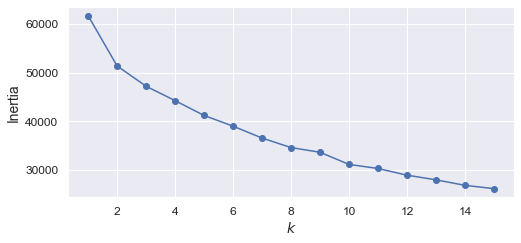

In [301]:
# KMeans
range_of_ks = range(1,16)
kmeans_per_k = [KMeans(n_clusters=k).fit(X_sub_rdkit_pca) for k in range_of_ks]

inertias = [model.inertia_ for model in kmeans_per_k]

plt.figure(figsize=(8, 3.5))
plt.plot(range_of_ks, inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.show()

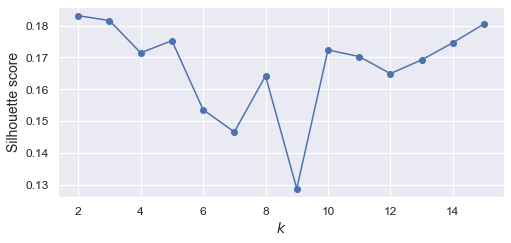

In [302]:
silhouette_scores = [silhouette_score(X_sub_rdkit_pca, model.labels_)
                     for model in kmeans_per_k[1:]]

plt.figure(figsize=(8, 3.5))
plt.plot(range_of_ks[1:], silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.show()

In [303]:
y_sub_rdkit = KMeans(13).fit_predict(X_sub_rdkit_pca)
y_sub_rdkit

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  6,  6,
        6,  6,  6,  6,  6, 10,  6, 11,  6,  1,  1,  1,  1,  4,  4,  8,  8,
        8,  8,  8,  8,  8,  8,  8,  4,  4,  4,  3,  3,  3,  3,  4,  3,  4,
       12, 12,  5,  5,  1,  1,  1,  1,  1,  1,  6,  7,  6,  6,  6,  6,  6,
        6,  6,  6,  6,  6,  8,  8,  8,  6,  6,  6,  6,  6,  6, 10, 10,  6,
        6,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  8,  8,  1,  1,
        1,  1,  0,  1,  6,  6,  4,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        4,  4,  8,  4,  4,  4,  4,  4,  0,  4,  8,  4,  4, 11,  4,  4,  4,
        0,  4,  4,  4,  4,  4,  4,  0,  4,  8,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  8,  4,  4,  4,  4,  4,  4,  4,  4,  4,  2,  4,  3, 10,  4,
        0,  4,  4,  3,  0,  4,  4,  8,  3,  3,  4,  4,  4,  3,  3,  3,  0,
        0,  0,  4,  0,  4,  0,  0,  0,  0,  0,  0,  4,  4,  4,  0, 10,  4,
        3,  3,  3,  3,  3,  0,  4,  0,  0,  4,  3,  0,  5,  0,  5, 12, 12,
       12, 12, 12, 12, 12

In [304]:
rndfor = RandomForestClassifier(n_estimators=500)
rndfor.fit(X_sub_rdkit, y_sub_rdkit)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [305]:
for name, imp in zip(rdkit_descriptors_subset.columns, rndfor.feature_importances_):
    print(name.ljust(20), round(imp,2))

MaxEStateIndex       0.01
MinEStateIndex       0.02
MaxAbsEStateIndex    0.01
MinAbsEStateIndex    0.01
qed                  0.01
MolWt                0.01
HeavyAtomMolWt       0.01
ExactMolWt           0.01
NumValenceElectrons  0.02
NumRadicalElectrons  0.0
MaxPartialCharge     0.02
MinPartialCharge     0.0
MaxAbsPartialCharge  0.0
MinAbsPartialCharge  0.02
FpDensityMorgan1     0.01
FpDensityMorgan2     0.01
FpDensityMorgan3     0.01
BCUT2D_MWHI          0.0
BCUT2D_MWLOW         0.0
BCUT2D_CHGHI         0.01
BCUT2D_CHGLO         0.01
BCUT2D_LOGPHI        0.0
BCUT2D_LOGPLOW       0.01
BCUT2D_MRHI          0.0
BCUT2D_MRLOW         0.02
BalabanJ             0.01
BertzCT              0.01
Chi0                 0.01
Chi0n                0.01
Chi0v                0.01
Chi1                 0.02
Chi1n                0.01
Chi1v                0.01
Chi2n                0.0
Chi2v                0.01
Chi3n                0.01
Chi3v                0.01
Chi4n                0.01
Chi4v               

# MORDERD Descriptors

In [175]:
# Finally, mordred descriptors
from mordred import Calculator, descriptors, error

In [176]:
# Initialise a calculator -- mordred works weirdly this way...
calc = Calculator(descriptors)

In [177]:
# Wow, many descriptors, much wow
len(calc.descriptors)

1826

In [178]:
mordred_descriptors = calc.pandas(rdkit_mols)

 16%|█▌        | 64/405 [00:05<01:02,  5.48it/s]

/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


100%|██████████| 405/405 [01:18<00:00,  5.15it/s]


In [179]:
mordred_descriptors

,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,LogEE_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,10.715992,9.304580,2,0,18.370637,2.259932,4.435888,18.370637,1.312188,3.560482,...,9.081484,58.361026,188.081044,8.549138,342,14,68.0,75.0,3.833333,3.166667
1,10.715992,9.304580,0,0,18.370637,2.259932,4.435888,18.370637,1.312188,3.560482,...,9.081484,58.361026,187.085795,8.134165,342,14,68.0,75.0,3.833333,3.166667
2,10.715992,9.304580,0,0,18.370637,2.259932,4.435888,18.370637,1.312188,3.560482,...,9.081484,58.361026,186.090546,7.753773,342,14,68.0,75.0,3.833333,3.166667
3,11.492048,10.070849,0,0,19.241292,2.321086,4.511537,19.241292,1.282753,3.629300,...,9.271718,60.342987,200.106196,7.411341,403,17,74.0,83.0,4.694444,3.361111
4,10.715992,9.304580,0,0,18.370637,2.259932,4.435888,18.370637,1.312188,3.560482,...,9.081484,58.361026,186.090546,7.753773,342,14,68.0,75.0,3.833333,3.166667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
400,19.217852,14.577842,0,0,31.530229,2.440229,4.850263,31.530229,1.313760,4.132888,...,10.207473,72.933632,334.088832,8.791811,1425,39,132.0,158.0,7.000000,5.138889
401,17.625299,13.419762,0,0,29.700756,2.423279,4.833309,29.700756,1.350034,4.049372,...,10.069891,70.381330,289.096360,8.760496,1112,34,120.0,143.0,5.277778,4.777778
402,22.005839,17.491326,0,1,36.641554,2.468925,4.787066,36.641554,1.308627,4.273880,...,10.259867,79.622966,416.108916,8.668936,2173,44,150.0,179.0,8.611111,6.166667
403,22.822336,17.990446,0,0,37.442910,2.472194,4.805734,37.442910,1.291135,4.308011,...,10.306450,80.832586,439.991693,11.578729,2402,46,156.0,186.0,9.472222,6.333333


In [279]:
mordred_descriptors.isnull().sum()

SMILES      0
ABC         0
ABCGG       0
nAcid       0
nBase       0
           ..
WPol        0
Zagreb1     0
Zagreb2     0
mZagreb1    0
mZagreb2    0
Length: 1428, dtype: int64

In [180]:
# It seems that unfortunately some descriptors cannot be computed. To filter this, 
# we find all columns that are of data type "object", since those contain non-numerical values usually.
error_columns = []
for i, e in enumerate(mordred_descriptors.dtypes):
    if e=="object":
        error_columns += [i]
error_columns

[780,
 781,
 782,
 783,
 784,
 785,
 786,
 787,
 788,
 789,
 790,
 791,
 792,
 793,
 794,
 795,
 796,
 797,
 798,
 799,
 800,
 801,
 802,
 803,
 804,
 805,
 806,
 807,
 808,
 809,
 810,
 811,
 812,
 813,
 814,
 817,
 818,
 819,
 820,
 821,
 822,
 906,
 907,
 908,
 909,
 910,
 911,
 912,
 913,
 914,
 915,
 916,
 917,
 918,
 919,
 1090,
 1091,
 1092,
 1093,
 1094,
 1095,
 1096,
 1097,
 1098,
 1099,
 1100,
 1101,
 1102,
 1103,
 1104,
 1105,
 1107,
 1108,
 1109,
 1110,
 1111,
 1112,
 1113,
 1114,
 1115,
 1116,
 1118,
 1119,
 1120,
 1121,
 1122,
 1123,
 1124,
 1125,
 1126,
 1127,
 1128,
 1129,
 1130,
 1131,
 1132,
 1133,
 1134,
 1135,
 1136,
 1137,
 1138,
 1139,
 1140,
 1141,
 1142,
 1143,
 1144,
 1145,
 1146,
 1147,
 1148,
 1149,
 1150,
 1151,
 1152,
 1153,
 1154,
 1155,
 1156,
 1157,
 1158,
 1159,
 1160,
 1161,
 1162,
 1163,
 1164,
 1165,
 1166,
 1167,
 1168,
 1169,
 1170,
 1171,
 1172,
 1173,
 1174,
 1175,
 1176,
 1177,
 1178,
 1179,
 1180,
 1181,
 1182,
 1183,
 1184,
 1186,
 1187,
 1188

In [181]:
# use .drop to remove the affected columns 
mordred_descriptors = mordred_descriptors.drop(mordred_descriptors.columns[error_columns], axis=1)

In [182]:
# and remove columns containing NAN data, but I don't think this actually does anything...
mordred_descriptors = mordred_descriptors.dropna(axis=1)

In [183]:
# again, insert first SMILES column
mordred_descriptors.insert(0, "SMILES", smiles_list)
mordred_descriptors

,SMILES,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,C[N]1N=NC(=N1)N=NC2=CC=CC=C2,10.715992,9.304580,2,0,18.370637,2.259932,4.435888,18.370637,1.312188,...,9.081484,58.361026,188.081044,8.549138,342,14,68.0,75.0,3.833333,3.166667
1,C[N]1C=NC(=N1)N=NC2=CC=CC=C2,10.715992,9.304580,0,0,18.370637,2.259932,4.435888,18.370637,1.312188,...,9.081484,58.361026,187.085795,8.134165,342,14,68.0,75.0,3.833333,3.166667
2,C[N]1C=CC(=N1)N=NC2=CC=CC=C2,10.715992,9.304580,0,0,18.370637,2.259932,4.435888,18.370637,1.312188,...,9.081484,58.361026,186.090546,7.753773,342,14,68.0,75.0,3.833333,3.166667
3,C[N]1C=C(C)C(=N1)N=NC2=CC=CC=C2,11.492048,10.070849,0,0,19.241292,2.321086,4.511537,19.241292,1.282753,...,9.271718,60.342987,200.106196,7.411341,403,17,74.0,83.0,4.694444,3.361111
4,C[N]1C=C(C=N1)N=NC2=CC=CC=C2,10.715992,9.304580,0,0,18.370637,2.259932,4.435888,18.370637,1.312188,...,9.081484,58.361026,186.090546,7.753773,342,14,68.0,75.0,3.833333,3.166667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
400,OC%38=C%39N=CC=CC%39=C(/N=N/C%40=NC%41=CC(C)=C...,19.217852,14.577842,0,0,31.530229,2.440229,4.850263,31.530229,1.313760,...,10.207473,72.933632,334.088832,8.791811,1425,39,132.0,158.0,7.000000,5.138889
401,OC%42=C%43N=CC=CC%43=C(/N=N/C%44=NC%45=CC=CC=C...,17.625299,13.419762,0,0,29.700756,2.423279,4.833309,29.700756,1.350034,...,10.069891,70.381330,289.096360,8.760496,1112,34,120.0,143.0,5.277778,4.777778
402,N#CC1C(SC(/N=N/C2=NC(C=CC([N+]([O-])=O)=C3)=C3...,22.005839,17.491326,0,1,36.641554,2.468925,4.787066,36.641554,1.308627,...,10.259867,79.622966,416.108916,8.668936,2173,44,150.0,179.0,8.611111,6.166667
403,N#Cc5c(c6ccc(Cl)cc6)c(/N=N/C7=NC(C=CC([N+]([O-...,22.822336,17.990446,0,0,37.442910,2.472194,4.805734,37.442910,1.291135,...,10.306450,80.832586,439.991693,11.578729,2402,46,156.0,186.0,9.472222,6.333333


In [207]:
#morgan = morgan_fingerprints.to_csv("morgan_fingerprints.csv")
# This is where I keep my csv file, you need to specify the path to your file!

# Use this line to get all columns of type float
# columns = chembl.columns[np.where(chembl.dtypes == "float64")] 

morgan_columns = mordred_descriptors.columns[1:].values.tolist()
#new_mordred_descriptors
morgan_columns

mordred_descriptors_subset = mordred_descriptors[morgan_columns].dropna()
mordred_descriptors_subset

,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,LogEE_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,10.715992,9.304580,2,0,18.370637,2.259932,4.435888,18.370637,1.312188,3.560482,...,9.081484,58.361026,188.081044,8.549138,342,14,68.0,75.0,3.833333,3.166667
1,10.715992,9.304580,0,0,18.370637,2.259932,4.435888,18.370637,1.312188,3.560482,...,9.081484,58.361026,187.085795,8.134165,342,14,68.0,75.0,3.833333,3.166667
2,10.715992,9.304580,0,0,18.370637,2.259932,4.435888,18.370637,1.312188,3.560482,...,9.081484,58.361026,186.090546,7.753773,342,14,68.0,75.0,3.833333,3.166667
3,11.492048,10.070849,0,0,19.241292,2.321086,4.511537,19.241292,1.282753,3.629300,...,9.271718,60.342987,200.106196,7.411341,403,17,74.0,83.0,4.694444,3.361111
4,10.715992,9.304580,0,0,18.370637,2.259932,4.435888,18.370637,1.312188,3.560482,...,9.081484,58.361026,186.090546,7.753773,342,14,68.0,75.0,3.833333,3.166667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
400,19.217852,14.577842,0,0,31.530229,2.440229,4.850263,31.530229,1.313760,4.132888,...,10.207473,72.933632,334.088832,8.791811,1425,39,132.0,158.0,7.000000,5.138889
401,17.625299,13.419762,0,0,29.700756,2.423279,4.833309,29.700756,1.350034,4.049372,...,10.069891,70.381330,289.096360,8.760496,1112,34,120.0,143.0,5.277778,4.777778
402,22.005839,17.491326,0,1,36.641554,2.468925,4.787066,36.641554,1.308627,4.273880,...,10.259867,79.622966,416.108916,8.668936,2173,44,150.0,179.0,8.611111,6.166667
403,22.822336,17.990446,0,0,37.442910,2.472194,4.805734,37.442910,1.291135,4.308011,...,10.306450,80.832586,439.991693,11.578729,2402,46,156.0,186.0,9.472222,6.333333


In [185]:
X_sub_morgan = mordred_descriptors_subset.to_numpy()


# PCA 
X_sub_morgan_scaled = StandardScaler().fit_transform(X_sub_morgan)
X_sub_morgan_pca = PCA(n_components=0.9).fit_transform(X_sub_morgan_scaled)
X_sub_morgan_pca

array([[-27.77118255,   2.25375041,   0.61748299, ...,  -3.69404124,
         -4.10968637,  -0.87720532],
       [-28.17588407,  -0.85114181,   1.75410178, ...,  -4.43703178,
         -4.40281166,  -0.60483219],
       [-27.92787864,  -5.25384518,   0.77128558, ...,   1.143308  ,
         -2.71858689,   0.82334525],
       ...,
       [ 37.95856198,   2.97445789,  17.94595813, ...,   1.27895911,
         -4.24516445,  -2.8700943 ],
       [ 32.63764927,  24.59617485,  24.73300482, ...,  -5.19910667,
          2.59721273,  -1.76155679],
       [ 46.64541384,   2.25239733,  15.30760162, ...,   2.32717086,
         -5.09690288,  -2.94142889]])

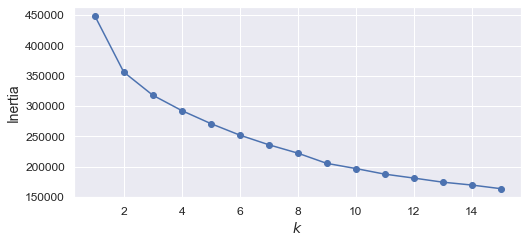

In [186]:
# KMeans
range_of_ks = range(1,16)
kmeans_per_k = [KMeans(n_clusters=k).fit(X_sub_morgan_pca) for k in range_of_ks]

inertias = [model.inertia_ for model in kmeans_per_k]

plt.figure(figsize=(8, 3.5))
plt.plot(range_of_ks, inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.show()

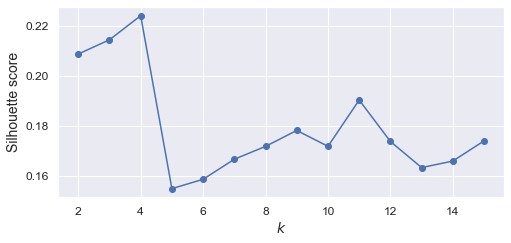

In [187]:
silhouette_scores = [silhouette_score(X_sub_morgan_pca, model.labels_)
                     for model in kmeans_per_k[1:]]

plt.figure(figsize=(8, 3.5))
plt.plot(range_of_ks[1:], silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.show()

In [188]:
y_sub_morgan = KMeans(4).fit_predict(X_sub_morgan_pca)
y_sub_morgan

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 2, 1, 0, 1, 1, 2, 2, 2, 2, 2, 2, 2, 0, 2, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1,
       1, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1,
       1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 0, 1, 1, 2, 1, 1, 0, 2, 1,
       1, 2, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 2, 1,
       1, 1, 1, 1, 2, 1, 0, 0, 0, 0, 0, 2, 1, 0, 0, 0, 0, 2, 2, 2, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 2, 1,
       1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1,

In [363]:
rndfor = RandomForestClassifier(n_estimators=1000, max_depth= 300)
rndfor.fit(X_sub_morgan, y_sub_morgan)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=300, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [364]:
for name, imp in zip(mordred_descriptors_subset.columns, rndfor.feature_importances_):
    if imp > 0.02:
        print(name.ljust(20), round(imp,5))

In [217]:
tsne = TSNE().fit_transform(X_sub_morgan_pca)

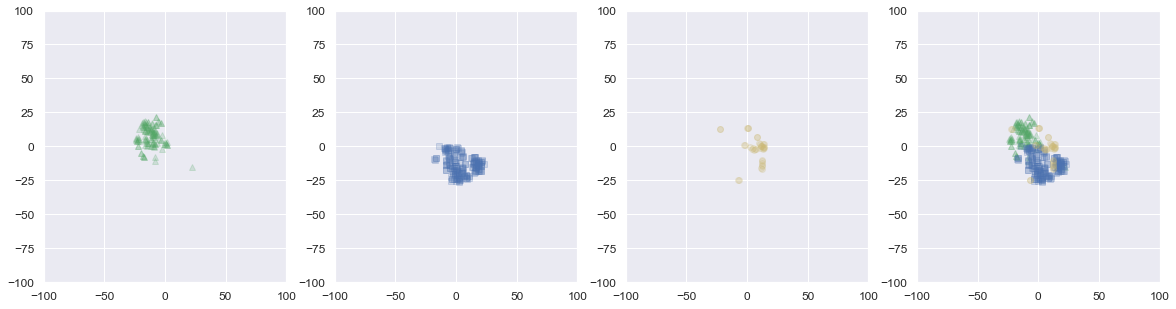

In [221]:
plt.figure(figsize=(20,5))

plt.subplot(141)
plt.plot(tsne[:,0][y_sub_morgan==0], tsne[:,1][y_sub_morgan==0], "g^", alpha=0.2)
plt.axis([-100, 100, -100, 100])

plt.subplot(142)
plt.plot(tsne[:,0][y_sub_morgan==1], tsne[:,1][y_sub_morgan==1], "bs", alpha=0.2)
plt.axis([-100, 100, -100, 100])

plt.subplot(143)
plt.plot(tsne[:,0][y_sub_morgan==2], tsne[:,1][y_sub_morgan==2], "yo", alpha=0.2)
plt.axis([-100, 100, -100, 100])

plt.subplot(144)
plt.plot(tsne[:,0][y_sub_morgan==0], tsne[:,1][y_sub_morgan==0], "g^", alpha=0.2)
plt.plot(tsne[:,0][y_sub_morgan==1], tsne[:,1][y_sub_morgan==1], "bs", alpha=0.2)
plt.plot(tsne[:,0][y_sub_morgan==2], tsne[:,1][y_sub_morgan==2], "yo", alpha=0.2)
plt.axis([-100, 100, -100, 100])

plt.show()

In [41]:
cd ~/Desktop/final_project_data

/Users/jimmmmmmmmyzzy/Desktop/final_project_data


In [44]:
# finally, generate images of molecules
from rdkit.Chem import Draw
for i,mol in enumerate(rdkit_mols):
    Draw.MolToFile(mol, filename =  str(i) + ".png")


In [45]:
Draw.MolToFile(mol, filename = "0.png")

In [46]:
photoswitches

,Unnamed: 0,SMILES,rate of thermal isomerisation from Z-E in s-1,Solvent used for thermal isomerisation rates,Z PhotoStationaryState,E PhotoStationaryState,E isomer pi-pi* wavelength in nm,Extinction,E isomer n-pi* wavelength in nm,Extinction coefficient in M-1 cm-1,...,TPSSh/6-31G** DFT Z isomer pi-pi* wavelength in nm,TPSSh/6-31G** DFT Z isomer n-pi* wavelength in nm,CAM-B3LYP/6-31G** DFT E isomer pi-pi* wavelength in nm,CAM-B3LYP/6-31G** DFT E isomer n-pi* wavelength in nm,CAM-B3LYP/6-31G** DFT Z isomer pi-pi* wavelength in nm,CAM-B3LYP/6-31G** DFT Z isomer n-pi* wavelength in nm,BHLYP/6-31G* DFT E isomer pi-pi* wavelength in nm,BHLYP/6-31G* DFT E isomer n-pi* wavelength in nm,BHLYP/6-31G* Z isomer pi-pi* wavelength in nm,BHLYP/6-31G* DFT Z isomer n-pi* wavelength in nm
0,0,C[N]1N=NC(=N1)N=NC2=CC=CC=C2,2.100000e-07,MeCN,76.0,72.0,310.0,1.67,442.0,0.0373,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,C[N]1C=NC(=N1)N=NC2=CC=CC=C2,3.800000e-07,MeCN,90.0,84.0,310.0,1.87,438.0,0.0505,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,C[N]1C=CC(=N1)N=NC2=CC=CC=C2,1.100000e-07,MeCN,98.0,97.0,320.0,1.46,425.0,0.0778,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,C[N]1C=C(C)C(=N1)N=NC2=CC=CC=C2,1.500000e-06,MeCN,96.0,87.0,325.0,1.74,428.0,0.0612,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,C[N]1C=C(C=N1)N=NC2=CC=CC=C2,7.600000e-09,MeCN,98.0,70.0,328.0,1.66,417.0,0.0640,...,295.0,410.0,305.0,427.0,256.0,401.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
400,400,OC%38=C%39N=CC=CC%39=C(/N=N/C%40=NC%41=CC(C)=C...,NaN,NaN,NaN,NaN,456.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
401,401,OC%42=C%43N=CC=CC%43=C(/N=N/C%44=NC%45=CC=CC=C...,NaN,NaN,NaN,NaN,437.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
402,402,N#CC1C(SC(/N=N/C2=NC(C=CC([N+]([O-])=O)=C3)=C3...,NaN,NaN,NaN,NaN,545.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
403,403,N#Cc5c(c6ccc(Cl)cc6)c(/N=N/C7=NC(C=CC([N+]([O-...,NaN,NaN,NaN,NaN,535.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Since fingerprints have no real-life equivalents as opposed to descriptors. In other words, they are just unlabelled data, and so we can start off by implementing some unsupervised learning algorithms.

In [46]:
# Dimensionality reduction
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"


In [47]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [48]:
from sklearn.datasets import make_swiss_roll, load_iris, fetch_openml, make_blobs, load_wine, make_moons, fetch_olivetti_faces
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.mixture import GaussianMixture
from sklearn.metrics import accuracy_score, silhouette_score, silhouette_samples
from sklearn.cluster import KMeans, DBSCAN, SpectralClustering, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE, Isomap, MDS, LocallyLinearEmbedding
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture

In [130]:
mordred_descriptors = mordred_descriptors.columns[1:].values.tolist()
columns = mordred_descriptors[np.where(mordred_descriptors.dtypes != "object")] 
photo_subset =new_mordred_descriptors[columns]
photo_subset

In [347]:
smiles_photoswitches = photoswitches["SMILES"].values

In [348]:
photoswitches_ec =photoswitches.groupby(['Extinction coefficient in M-1 cm-1'], as_index=False).first()


In [349]:
smiles_photoswitches_for_ec_cal = photoswitches_ec["SMILES"]
extinction_coefficient_photoswitches_for_ec_cal  = photoswitches_ec["Extinction coefficient in M-1 cm-1"]

In [350]:
# Now, it's time to split our data set into training & test group
Train, Test, TrainTargets , TestTargets = train_test_split(smiles_photoswitches_for_ec_cal , extinction_coefficient_photoswitches_for_ec_cal, test_size=0.25,random_state=42) #Yeah the magical 42
print("We have", len(Test), "molecules in the test set, out of a total of", len(smiles_photoswitches_for_ec_cal ))



We have 5 molecules in the test set, out of a total of 18


In [351]:
# Convert a single SMILES to RDKIT molecule format
def SMILES2MOL(mole):
    return Chem.MolFromSmiles(mole)
# Convert an array/vector of SMILES data to RDKIT mole format
def SMILES2MOLES(moles):
    vectSMILES2MOL=np.vectorize(SMILES2MOL)
    return vectSMILES2MOL(moles)

In [352]:
# Convert into a different format (rdkit internal)
PTR= SMILES2MOLES(Train)
PTE= SMILES2MOLES(Test)

In [357]:
#V1
# Choosing the descriptors for training (ECTR) and test (ECTE) sets of extinction coefficients. 
from rdkit.Chem import Descriptors

ECTR=[]
for m in PTR:
    desc=[]
    desc.append(Descriptors.MaxEStateIndex (m)) # Total polar surface area
    desc.append(Descriptors.ExactMolWt(m)) # The exact molecular weight 
    ECTR.append(desc)
    
ECTE=[]
for m in PTE:
    desc=[]
    desc.append(Descriptors.MaxEStateIndex (m))  
    desc.append(Descriptors.ExactMolWt(m)) 
    ECTE.append(desc)

In [358]:
# 
from sklearn.gaussian_process import GaussianProcessRegressor 
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.gaussian_process.kernels import Matern, WhiteKernel
kernel=RBF(length_scale_bounds=(5e-02,10)) 

gp=GaussianProcessRegressor(kernel=kernel,normalize_y=True,n_restarts_optimizer=10,alpha=1e-4);

# Fit our GP model
gp.fit(ECTR,TrainTargets);

In [359]:
# Use the trained GP to predict the solubility of our training set...
TrainPred=gp.predict(ECTR).reshape(-1,1)
# ... and of our test set
TestPred=gp.predict(ECTE).reshape(-1,1)

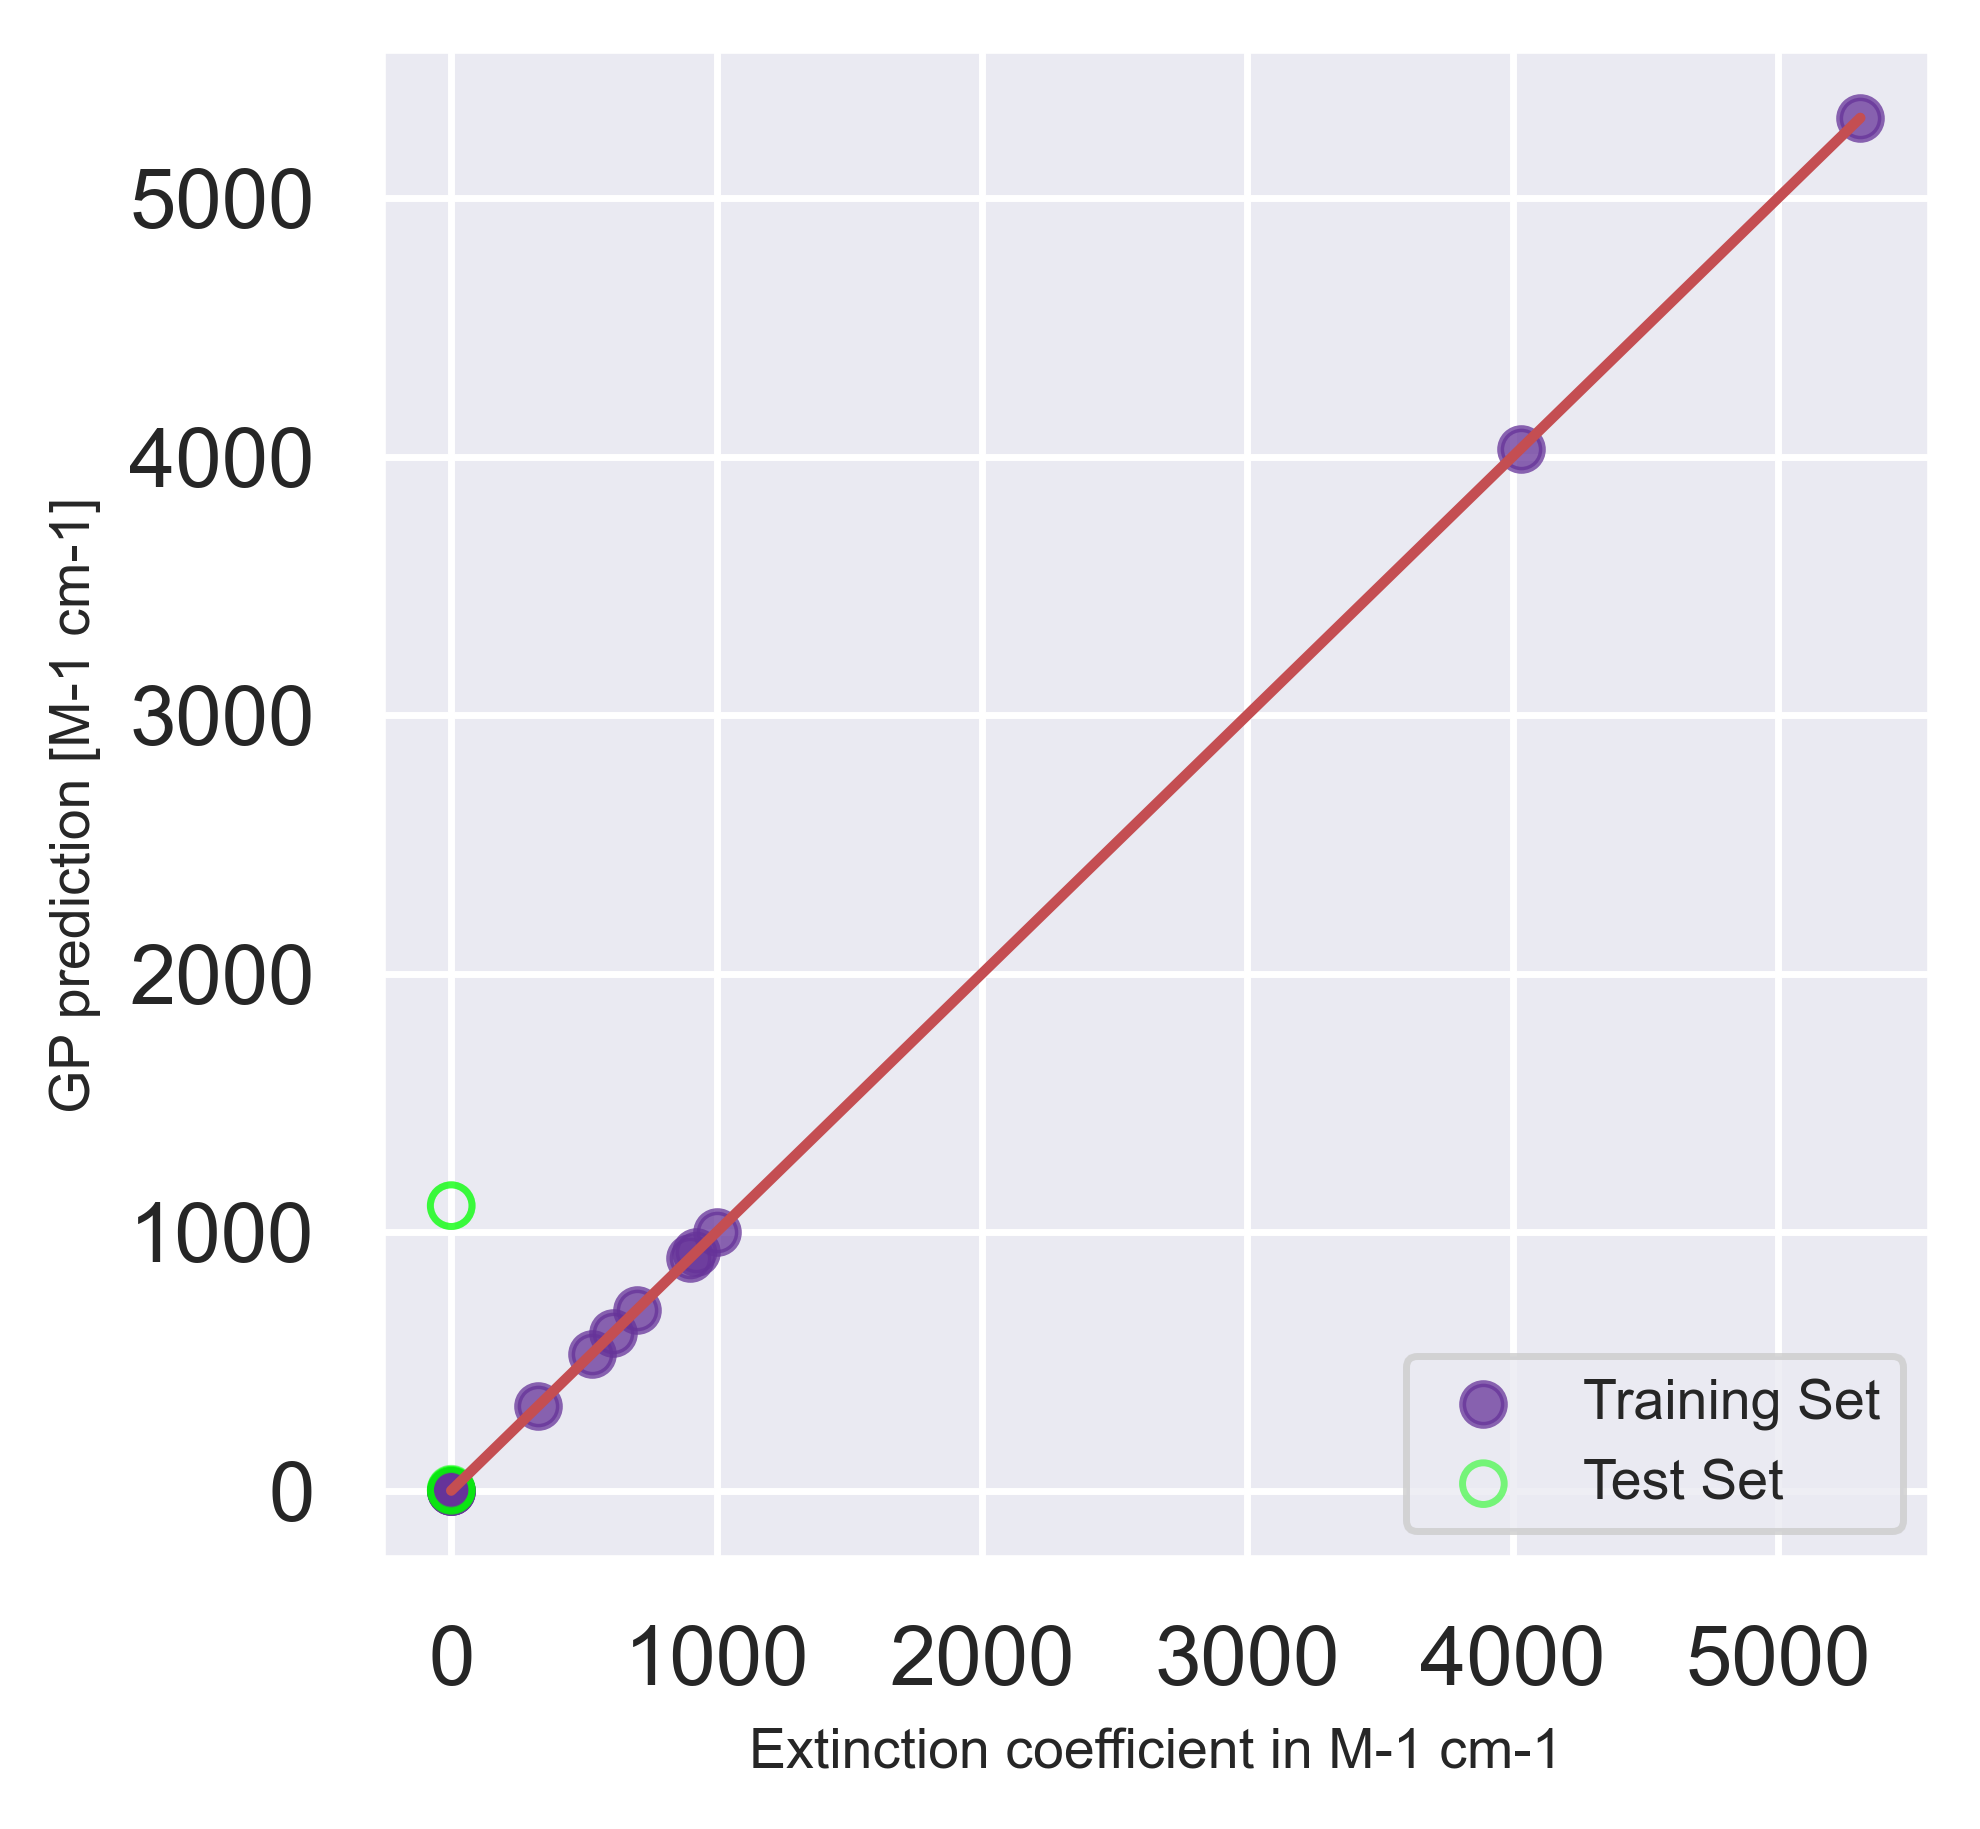

In [360]:
# Let's have a look!
fig=plt.figure(num=None,figsize=(4,4),dpi=500,facecolor='w',edgecolor='k')
plt.xlabel('Extinction coefficient in M-1 cm-1',fontsize=8)
plt.ylabel('GP prediction [M-1 cm-1]',fontsize=8)
x = np.linspace(min(TrainTargets), max(TrainTargets), 1000)
plt.plot(x, x + 0, '-r')
plt.scatter(TrainTargets,TrainPred,color='rebeccapurple',alpha=0.75,label='Training Set')
plt.scatter(TestTargets,TestPred,color='lime',alpha=0.5,label='Test Set',facecolors='none')
plt.legend(fontsize=8,loc=4);

